In [46]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense,Dropout,GRU,LSTM
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow import keras

import pickle
from pickle import dump,load

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline 

### Import Data

In [78]:
df = pd.read_csv('data/data_rnn.csv')

In [79]:
#Raname columns
df.rename(columns={'Unnamed: 0':'date'},inplace=True)

In [80]:
##Data Cleaning
df.set_index('date',inplace=True)
df.sort_index(inplace=True)
df.head(25)

,mentions,followers,price,target
date,,,,
2021-01-01,2.0,1.720597e+09,17.25,0
2021-01-02,1.0,1.633288e+09,17.25,0
2021-01-03,2.0,1.043636e+09,17.25,0
2021-01-04,2.0,1.760137e+09,17.25,0
2021-01-05,2.0,2.277719e+09,17.37,0
2021-01-06,1.0,1.621527e+09,18.36,1
2021-01-07,3.0,2.278927e+09,18.08,1
2021-01-08,2.0,2.059609e+09,17.69,1
2021-01-09,3.0,2.015346e+09,17.69,1


Feature engineering for time series modelling

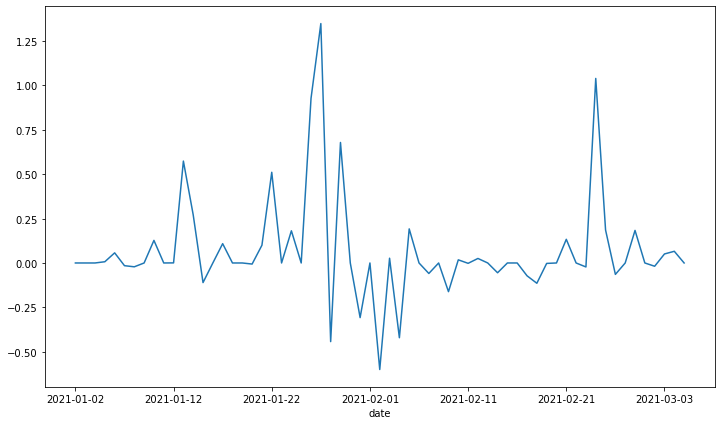

In [81]:
#Remove any possible trend from the data
df['price'] = df['price'].pct_change()

#Create a cumulative sum of the count of mentions 
#Hype aroudn GME built over time, so it will help the model pickup on trends if we use the cumulagive mentions 
#over time 
df['cum_mentions'] = df['mentions'].cumsum()
df.dropna(inplace=True)

#Diplsay the de-trended the data
df['price'].plot(figsize=(12,7));

Baseline score

In [82]:
df['target'].mean()

0.5873015873015873

### Prepare our X,Y and train-test split

In [89]:
df.head()

,mentions,followers,price,target,cum_mentions
date,,,,,
2021-01-02,1.0,1.633288e+09,0.000000,0,3.0
2021-01-03,2.0,1.043636e+09,0.000000,0,5.0
2021-01-04,2.0,1.760137e+09,0.000000,0,7.0
2021-01-05,2.0,2.277719e+09,0.006957,0,9.0
2021-01-06,1.0,1.621527e+09,0.056995,1,10.0


In [90]:
#Create X and Y 
X = df.drop(columns=['target','mentions'])
y = df['target'].values # turn this into a numpy array

#Create train-test split
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False)

### Scaling and pre-porcessing the data

In [91]:
#Scaling
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [92]:
#Convert data to a series using Time Series Generator
train_sequences = TimeseriesGenerator(X_train_sc,y_train,length=3,batch_size=128)
test_sequences = TimeseriesGenerator(X_test_sc,y_test,length=3,batch_size=128)

### Neural net design and architecture definition

In [93]:
#Design RNN

model = Sequential()

model.add(GRU(X_train.shape[1],input_shape=(3,X_train.shape[1]),return_sequences=True)) #True b/c next layer is also rnn

model.add(GRU(X_train.shape[1],return_sequences=False))

model.add(Dense(4,activation='relu'))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer=Adam(),
             metrics=['accuracy'])

### Fit model and create predictions

In [94]:
#Fit model
history = model.fit_generator(train_sequences,
                   epochs=30,
                   validation_data=test_sequences)

/Users/noah/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
1/1 [==============================] - 10s 10s/step - loss: 0.6699 - accuracy: 0.7273 - val_loss: 0.6664 - val_accuracy: 0.6154
Epoch 2/30
1/1 [==============================] - 0s 129ms/step - loss: 0.6687 - accuracy: 0.8182 - val_loss: 0.6662 - val_accuracy: 0.6154
Epoch 3/30
1/1 [==============================] - 0s 151ms/step - loss: 0.6674 - accuracy: 0.8409 - val_loss: 0.6660 - val_accuracy: 0.6154
Epoch 4/30
1/1 [==============================] - 0s 130ms/step - loss: 0.6661 - accuracy: 0.8409 - val_loss: 0.6658 - val_accuracy: 0.6154
Epoch 5/30
1/1 [==============================] - 0s 105ms/step - loss: 0.6648 - accuracy: 0.8409 - val_loss: 0.6656 - val_accuracy: 0.6154
Epoch 6/30
1/1 [==============================] - 0s 176ms/step - loss: 0.6635 - accuracy: 0.8409 - val_loss: 0.6654 - val_accuracy: 0.6154
Epoch 7/30
1/1 [==============================] - 0s 92ms/step - loss: 0.6622 - accuracy: 0.8409 - val_loss: 0.6653 - val_accuracy: 0.6923
Epoch 8/30
1/1 [======

In [95]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

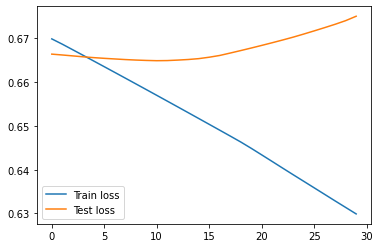

In [96]:
plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label='Test loss')
plt.legend();

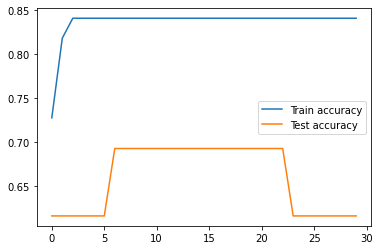

In [97]:
plt.plot(history.history['accuracy'],label='Train accuracy')
plt.plot(history.history['val_accuracy'],label='Test accuracy')
plt.legend();

In [98]:
model.predict_classes(test_sequences)

/Users/noah/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1]], dtype=int32)

In [99]:
y_test

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Export the model 

In [102]:
#save model to disk
model.save('assets/rrn_model.csv')

#model = keras.models.load_model('assets/rrn_model.csv')

INFO:tensorflow:Assets written to: assets/rrn_model.csv/assets


INFO:tensorflow:Assets written to: assets/rrn_model.csv/assets


In [105]:
#Save history for analysis
with open('data/rnn_train_history.csv','wb') as file_pi:
    pickle.dump(history.history,file_pi)

In [ ]:
#Save standard scaler
dump(ss,open('assets/scaler.pkl','wb'))

### Making Predictions

In [19]:
#Load and transform the data
df = pd.read_csv('data/merge.csv')
df.rename(columns={'Unnamed: 0':'date'},inplace=True)
df.set_index('date',inplace=True)
df.sort_index(inplace=True)
df.dropna(inplace=True)

In [9]:
model = keras.models.load_model('assets/rrn_model.csv')
scaler = load(open('assets/scaler.pkl','rb'))

In [20]:
#Create X and Y 
X = df.drop(columns=['target','mentions'])
y = df['target'].values 

In [21]:
#Scale the data
X_sc = scaler.transform(X)

In [22]:
#Convert data to a series using Time Series Generator
test_sequences = TimeseriesGenerator(X_sc,y,length=3,batch_size=128)

In [23]:
#Create predictions
preds = model.predict_classes(test_sequences)

/Users/noah/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [68]:
#Layer in dates as index to predictions dataframe
dates = pd.date_range(start='2021-03-09',end='2021-04-02')
predictions = dates.to_frame()
predictions['buy_or_sell'] = preds
predictions.drop([0],axis=1,inplace=True)

In [64]:
#Show predictions
predictions

,buy_or_sell
2021-03-09,1
2021-03-10,1
2021-03-11,1
2021-03-12,1
2021-03-13,1
2021-03-14,1
2021-03-15,1
2021-03-16,1
2021-03-17,1
2021-03-18,1
